# Visualize spectra using embedding umap
This notebooks creates a 2D visualization of the case study spectrum set. By using Umap the multidiminsional embeddings are reduced to 2 dimensions. Annotations are added to make a interactive visualization possible

# Download model, spectra and annotations

In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
model_file_name = "ms2deepscore_model.pt"
case_study_spectra_file_name = "case_study_spectra.mgf"
ms2query_annotations = "ms2query_annotations.csv"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14290920/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/14535374/files/cleaned_spectra_pos_neg_with_numbering.mgf?download=1", case_study_spectra_file_name)
download_file("https://zenodo.org/records/14535374/files/ms2query_annotations.csv?download=1", ms2query_annotations)



### Load ms2deepscore model

In [7]:
from ms2deepscore.models import load_model
model = load_model(model_file_name)

c:\users\jonge094\pycharmprojects\ms2deepscore\ms2deepscore\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(f

In [8]:
from ms2deepscore import MS2DeepScore
ms2ds_model = MS2DeepScore(model)

### load spectra
The spectra are precprocessed in the notebook pre_processing_spectra.ipynb

In [2]:
from matchms.importing import load_from_mgf
from tqdm import tqdm
spectra = list(tqdm(load_from_mgf(case_study_spectra_file_name)))

2909it [00:01, 1808.13it/s]


### Create embeddings
MS2Deepscore embeddings are a 500 dimensional representation of a spectrum. Similar embeddings should correspond to similar molecules.

In [208]:
ms2ds_embeddings = ms2ds_model.get_embedding_array(spectra)

2909it [00:03, 896.63it/s]


In [209]:
ms2ds_embeddings.shape

(2909, 500)

### Fit Umap
Umap is a method for reducing multidimensional data to 2 dimensions. This is done in a way that aims to keep distances between embeddings close to the thruth. However, since reducing from 500 dementions some distortions always take place. Reducing to 2 dimensions allows us to visualize the embeddings.

The code below tries to learn how to best transform 500 dimensions to 2 dimensions.

In [210]:
import umap

reducer = umap.UMAP(random_state=42,  # this or whatever your favorite number is
                    n_neighbors=50 ,  # key parameters How global or local the distribution 30, 50
                    min_dist=0.2 , # can the dots overlap if you use 5 they move out a bit. 0.1, 0.2
                    )
reducer.fit(ms2ds_embeddings)

/lustre/BIF/nobackup/jonge094/bin/miniconda3/envs/ms2deepscore/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(min_dist=0.2, n_jobs=1, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

### get 2d coordinates from embeddings
Here we use the fitted umap model to actually transform embeddings to a x and y coordinate

In [211]:
embedding_umap = reducer.transform(ms2ds_embeddings)

### Convert to pandas df
Use the query_spectrum_id from the spectra as index for the pandas dataframe

In [212]:
import pandas as pd
embedding_umap_df = pd.DataFrame(embedding_umap, 
                                 index = [spectrum.get("query_spectrum_nr") for spectrum in spectra],
                                columns = ["x", "y"])
indexes = embedding_umap_df.index
embedding_umap_df["query_spectrum_nr"] = indexes

### Visualize embeddings
We use plotly to visualize the embeddings of the spectra

In [213]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [214]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(embedding_umap_df,
    x="x",
    y="y",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    width=800,
    height=800,
)

fig.show()

### Add annotations to visualization
Visualizing just the embeddings is not very informative. Below we add the ms2query annotations, but any information can be added in principle. 


In [215]:
ms2query_annotations = pd.read_csv(ms2query_annotations)

### Merge annotations with umap table

In [216]:
merged_data = pd.merge(embedding_umap_df, ms2query_annotations, on="query_spectrum_nr", how= "outer")

In [217]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(merged_data.iloc[::-1],
    x="x",
    y="y",
    color="ionmode",
    color_discrete_map={"positive": "#C6DBEF", "negative": "#FCBBA1"},

    # color_continuous_scale="viridis",
    size_max=50,
    opacity=1.0,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                # "fraction": True,
                "precursor_mz_difference": False,
               "ionmode": True,
               "ms2query_model_prediction": False,
               "smiles": True,
               "analog_compound_name": True,
                "precursor_mz_query_spectrum": True, 
               "rtinminutes": True,
               "query_spectrum_nr": True},
    # symbol="cf_superclass",
    width=800,
    height=800,
)
# Update background colors
fig.update_layout(
    plot_bgcolor='white',  # Set the plot area background color
    paper_bgcolor='white',    # Set the figure background color
)

# Update grid line colors
fig.update_xaxes(
    gridcolor='gray',          # Grid lines on x-axis
    zerolinecolor='gray'      # Line at x=0
)
fig.update_yaxes(
    gridcolor='gray',          # Grid lines on y-axis
    zerolinecolor='gray'      # Line at y=0
)

fig.update_traces(marker=dict(size=5))  # Increase size to 12 (default is typically smaller)

fig.show()

In [193]:
fig.write_html("embedding_visualization_red_blue.html")

### Create zoomed in versions

In [218]:
fig.update_layout(
    xaxis=dict(range=[0, 18],
              dtick=2),  # Set x-axis zoom range (adjust as needed)
    yaxis=dict(range=[0, 18],
              dtick=2)   # Set y-axis zoom range (adjust as needed)
)

In [219]:
# percentage of umap dots excluded with specified zoom
nr_of_spectra_outside_range = merged_data[(merged_data['x'] > 18) | (merged_data['x'] < 0) | (merged_data['y'] > 18) | (merged_data['y'] < 0)].shape[0]
print(f"nr of spectra outside range of 0-18: {nr_of_spectra_outside_range/merged_data.shape[0]*100:.1f} %")


nr of spectra outside range of 0-18: 4.6 %


In [220]:
fig.update_layout(
    xaxis=dict(range=[7.99, 10.01]),  # Set x-axis zoom range (adjust as needed)
    yaxis=dict(range=[3.99, 6.01])   # Set y-axis zoom range (adjust as needed)
)
fig.update_traces(marker=dict(size=15))  # Increase size to 12 (default is typically smaller)

fig.show()

### Find interesting examples with reliable MS2Query annotations in both ionmodes

In [221]:
# get all ms2query scores above 0.8
high_ms2query_score = merged_data[(merged_data['ms2query_model_prediction'] > 0.8)]
high_ms2query_score['precursor_mz_difference'].astype(float)
# and mass diff < 0.1 Da
high_ms2query_exact_matches = high_ms2query_score[(high_ms2query_score['precursor_mz_difference'].astype(float) < 0.1)]
# Get the cases that have at least 1 pos and 1 neg example
has_pos_and_neg = high_ms2query_exact_matches.groupby('inchikey')['ionmode'].apply(lambda x: {'positive', 'negative'}.issubset(set(x)))
result = high_ms2query_exact_matches[high_ms2query_exact_matches['inchikey'].isin(has_pos_and_neg[has_pos_and_neg].index)]


In [222]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

result.sort_values(by='inchikey')


,x,y,query_spectrum_nr,Unnamed: 0,ms2query_model_prediction,precursor_mz_difference,precursor_mz_query_spectrum,precursor_mz_analog,inchikey,analog_compound_name,smiles,rtinminutes,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class_results,npc_superclass_results,npc_pathway_results,ionmode
2645,8.732002,4.953363,pos_761,759.0,0.9240,0.0007,355.2637,355.2630,BHQCQFFYRZLCQQ,Cholic acid,[H][C@@]12C[C@H](O)CC[C@]1(C)[C@@]1([H])C[C@H](O)[C@]3(C)[C@]([H])(CC[C@@]3([H])[C@]1([H])[C@H](O)C2)[C@H](C)CCC(O)=O,9.736050,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,positive
1857,8.766818,5.022066,pos_1487,1484.0,0.8788,0.0020,373.2760,373.2740,BHQCQFFYRZLCQQ,"""(4R)-4-((3R,5S,7S,8R,9S,10S,12R,13R,17R)-3,7,12-trihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid""",[H][C@]1([C@]2(C)[C@H](O)C[C@@]3([H])[C@@]1([H])[C@@H](O)C[C@@]4([H])[C@]3(C)CC[C@@H](O)C4)CC[C@@H]2[C@@H](CCC(O)=O)C,8.105700,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,positive
1865,8.699626,5.012659,pos_1494,1491.0,0.8788,0.0016,355.2646,355.2630,BHQCQFFYRZLCQQ,Cholic acid,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C,8.391133,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,positive
259,8.805410,5.069621,neg_1231,2822.0,0.9585,0.0006,407.2797,407.2803,BHQCQFFYRZLCQQ,Cholic acid; LC-tDDA; CE30,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@]12C,9.724466,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,negative
2573,8.718931,5.017680,pos_697,695.0,0.8788,0.0016,355.2646,355.2630,BHQCQFFYRZLCQQ,Cholic acid,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C,8.391133,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,positive
2566,8.784904,4.982005,pos_690,688.0,0.8788,0.0020,373.2760,373.2740,BHQCQFFYRZLCQQ,"""(4R)-4-((3R,5S,7S,8R,9S,10S,12R,13R,17R)-3,7,12-trihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid""",[H][C@]1([C@]2(C)[C@H](O)C[C@@]3([H])[C@@]1([H])[C@@H](O)C[C@@]4([H])[C@]3(C)CC[C@@H](O)C4)CC[C@@H]2[C@@H](CCC(O)=O)C,8.105700,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,positive
1936,8.794638,4.975370,pos_1558,1555.0,0.9240,0.0007,355.2637,355.2630,BHQCQFFYRZLCQQ,Cholic acid,[H][C@@]12C[C@H](O)CC[C@]1(C)[C@@]1([H])C[C@H](O)[C@]3(C)[C@]([H])(CC[C@@]3([H])[C@]1([H])[C@H](O)C2)[C@H](C)CCC(O)=O,9.736050,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,"Bile acids, alcohols and derivatives","Trihydroxy bile acids, alcohols and derivatives",Cholane steroids,Steroids,Terpenoids,positive
602,9.614359,11.098473,neg_357,1948.0,0.8124,0.0003,135.0315,135.0312,FDGQSTZJBFJUBT,Hypoxanthine; LC-tDDA; CE10,Oc1ncnc2[nH]cnc12,1.167733,Organic compounds,Organoheterocyclic compounds,Imidazopyrimidines,Purines and purine derivatives,Hypoxanthines,Purine alkaloids,Pseudoalkaloids,Alkaloids,negative
2878,9.741734,13.196935,pos_971,969.0,0.9150,0.0020,137.0441,137.0461,FDGQST

# plot example spectra
Based on these results we pick the first pos and neg example

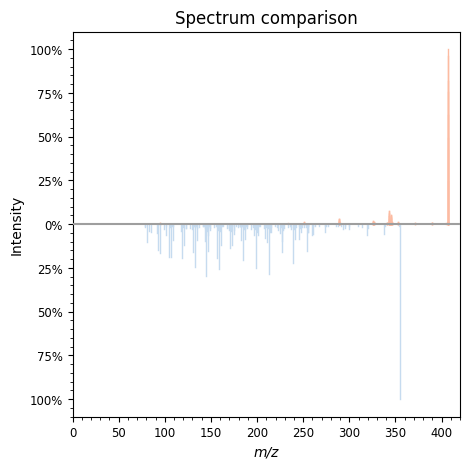

In [5]:
from matchms.plotting.spectrum_plots import plot_spectra_mirror
import matplotlib.pyplot as plt
selected_spectra =[spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") in ["neg_1231", "pos_761", ]]
# Set compound name to empty string, since matchms by default prints the compound name
selected_spectra[0].set("compound_name", "")
selected_spectra[1].set("compound_name", "")
plt.figure(figsize=(5, 5))
fig = plot_spectra_mirror(selected_spectra[1], selected_spectra[0], grid=False, 
                          max_mz=420,
                          color_top = "#FCBBA1",
                          color_bottom="#C6DBEF"
                         )
 # "positive": "#C6DBEF", "negative": "#FCBBA1"
plt.savefig("./spectrum_comparison_cholin_acid.svg", bbox_inches='tight')

In [6]:
print(selected_spectra[0].metadata)
print(selected_spectra[1].metadata)

{'title': 'Unknown; Ms1ScanNumber: 2367; Ms2ScanNumber: 2368', 'charge': 1, 'scans': '295', 'rtinminutes': '9.73605', 'ion': '[M+H-H2O]+', 'precursor_mz': 355.2637, 'fraction': '75', 'compound_name': '', 'ionmode': 'positive', 'parent_mass': '354.2564235480092', 'query_spectrum_nr': 'pos_761'}
{'title': 'Unknown; Ms1ScanNumber: 479; Ms2ScanNumber: 480', 'charge': -1, 'scans': '737', 'rtinminutes': '9.724466', 'ion': '[M-H]-', 'precursor_mz': 407.2797, 'fraction': '75', 'compound_name': '', 'ionmode': 'negative', 'parent_mass': '408.28697645199077', 'query_spectrum_nr': 'neg_1231'}


#### Get (modified) cosine score and MS2Deepscore for example spectrum pair

In [12]:
import matchms.similarity as mssim
selected_spectra =[spectrum for spectrum in spectra if spectrum.get("query_spectrum_nr") in ["neg_1231", "pos_1558", ]]

similarity_cosine = mssim.CosineGreedy(tolerance=0.1).pair(selected_spectra[0], selected_spectra[1])
similarity_modified_cosine = mssim.ModifiedCosine(tolerance=0.1).pair(selected_spectra[0], selected_spectra[1])
ms2deepscore_score = ms2ds_model.pair(selected_spectra[0], selected_spectra[1])
print(f"MS2Deepscore: {ms2deepscore_score:.3f}")
print(f"Cosine score: {similarity_cosine['score']:.3f}")
print(f"Modified cosine score: {similarity_modified_cosine['score']:.3f}")

1it [00:00, 22.37it/s]
1it [00:00, 38.50it/s]

MS2Deepscore: 0.785
Cosine score: 0.000
Modified cosine score: 0.355


# Plot with superclass overlay
MS2Query adds classifier annotations. These can be used to visualize the spectra. 

In [188]:
import plotly.express as px
import numpy as np

# Create scatter plot using Plotly Express
fig = px.scatter(merged_data,
    x="x",
    y="y",
    color="cf_superclass",
    color_discrete_map={"unknown": 'lightgrey'},

    # color_continuous_scale="viridis",
    size_max=50,
    opacity=0.5,
    title='UMAP projection MS2DeepScore embeddings',
    hover_data={"x": False,
                "y": False,
                # "fraction": True,
                "precursor_mz_difference": True,
               "ionmode": True,
               "ms2query_model_prediction": True,
               "smiles": True,
               "analog_compound_name": True,
               "rtinminutes": True},
    # symbol="ionmode",
    width=1000,
    height=800,
)

fig.show()


In [189]:
fig.write_html("embedding_visualization_compound_classes.html")

### Visualize molecular structures
Below you can create an interactive plot, that draws the molecular structure directly on top of the plot. 
The molecular structures are drawn based on MS2Query annotations.

In [20]:
merged_data = merged_data[merged_data["smiles"] != "unknown"]

In [21]:
# make number
merged_data.loc[:, "rtinminutes"] = merged_data["rtinminutes"].astype(float)

In [26]:
port = 8000

In [ ]:
import pandas as pd
import plotly.express as px

import molplotly

# load a DataFrame with smiles
df_esol = pd.read_csv(
    'https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv')
df_esol['y'] = df_esol['ESOL predicted log solubility in mols per litre']
df_esol['x'] = df_esol['measured log solubility in mols per litre']

fig = px.scatter(merged_data,
    x="x",
    y="y",
    color="ionmode",
    symbol="cf_superclass",
    width=1200,
    height=800,
)

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                              df=merged_data,
                              smiles_col='smiles',
                              color_col="ionmode",
                              caption_cols=['rtinminutes', "ionmode", "precursor_mz_query_spectrum", "analog_compound_name"],
                              show_coords=False,
                              symbol_col="cf_superclass"
                            )

port += 1 # If you want to recreate a plot the port has to not be used before (this makes it easy to not forget increasing the port)

# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=port, height=1000)